Importando as bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import datetime

Importar e tratando a base de dados

In [ ]:
original_dataset = pd.read_csv('comercial_valor.csv', sep=";")

display(original_dataset.iloc[51,:])
display(original_dataset.iloc[87,:])


# tratando os dados da covid
data_ini = datetime.date(2020, 3, 1)
data_fin = datetime.date(2021, 4, 1)

for i in original_dataset.index:

  data_aux = datetime.date(original_dataset.loc[i, 'Ano'], original_dataset.loc[i, 'Mes'], 1)

  if data_aux >= data_ini and data_aux <= data_fin:

    if data_aux == data_ini or data_aux == data_ini + pd.DateOffset(months=1):

      original_dataset.loc[i, 'Venda'] = (original_dataset.loc[i-12, 'Venda'] + original_dataset.loc[i+24, 'Venda'])/2

    else:

      original_dataset.loc[i, 'Venda'] = (original_dataset.loc[i-12, 'Venda'] + original_dataset.loc[i+12, 'Venda'])/2



display(original_dataset.iloc[63,:])

#display(original_dataset.head())
display(original_dataset.Ano.value_counts())

dataset = original_dataset.copy()
dataset["data"] = original_dataset["Mes"].astype(str) + '-' + original_dataset["Ano"].astype(str)
display(dataset.head())

dataset["Venda"]=dataset["Venda"].astype(int)

dataset.index = dataset['data']
dataset = dataset.drop(columns=['Ano', 'Mes', 'data'])
display(dataset.head())

print(dataset.shape)

Ano         2019
Mes            4
Venda    3222427
Name: 51, dtype: int64

Ano         2022
Mes            4
Venda    4704635
Name: 87, dtype: int64

<ipython-input-118-154a4dc212a8>:17: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if data_aux == data_ini or data_aux == data_ini + pd.DateOffset(months=1):


Ano         2020.0
Mes            4.0
Venda    3963531.0
Name: 63, dtype: float64

2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022    12
2023     4
Name: Ano, dtype: int64

,Ano,Mes,Venda,data
0,2015,1,2374481.0,1-2015
1,2015,2,2037942.0,2-2015
2,2015,3,2495664.0,3-2015
3,2015,4,2483449.0,4-2015
4,2015,5,3895269.0,5-2015


,Venda
data,
1-2015,2374481
2-2015,2037942
3-2015,2495664
4-2015,2483449
5-2015,3895269


(100, 1)


Normalizando os dados de venda

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(dataset)

scaled_df = pd.DataFrame(d)
scaled_df = scaled_df.rename(columns={0: "venda"})
scaled_df.head()

,venda
0,0.045675
1,0.000000
2,0.062122
3,0.060464
4,0.252075


Visualizar Série Histórica

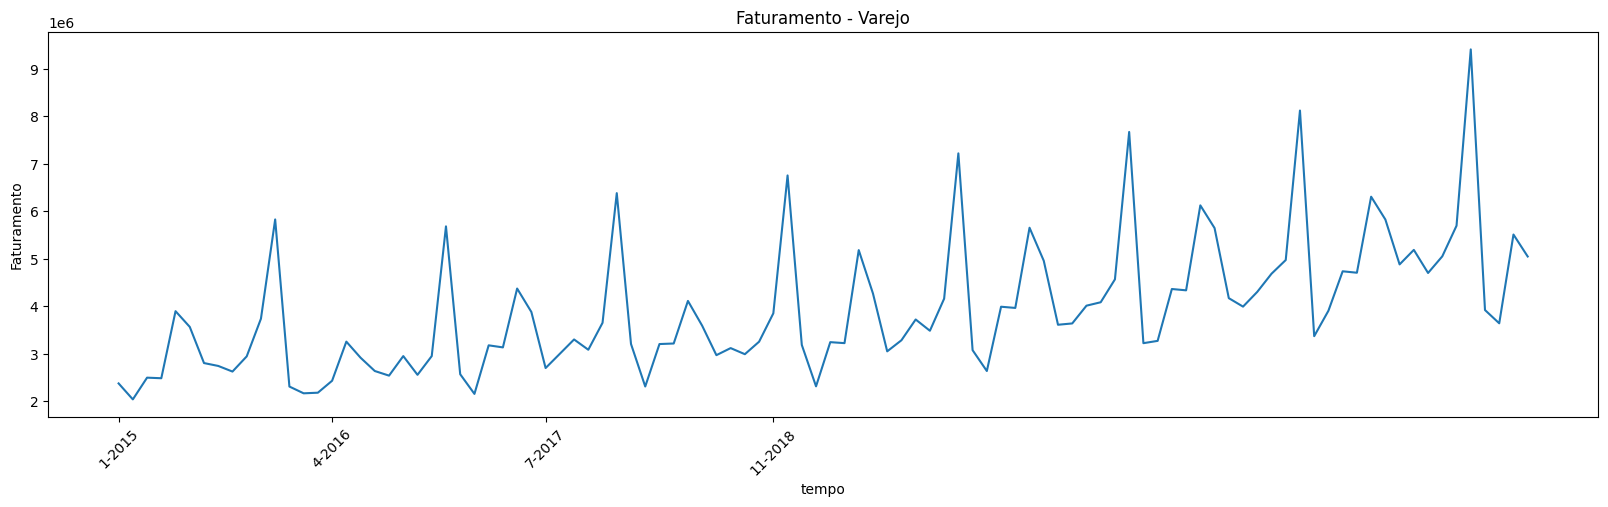

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(dataset)
plt.xlabel("tempo")
plt.ylabel("Faturamento")
plt.title("Faturamento - Varejo")
plt.xticks([0,15,30,46], rotation=45) # coloca somente 4 valores no eixo x e rotaciona 45 graus por questões de visualização
plt.show()

Comportamento Anual

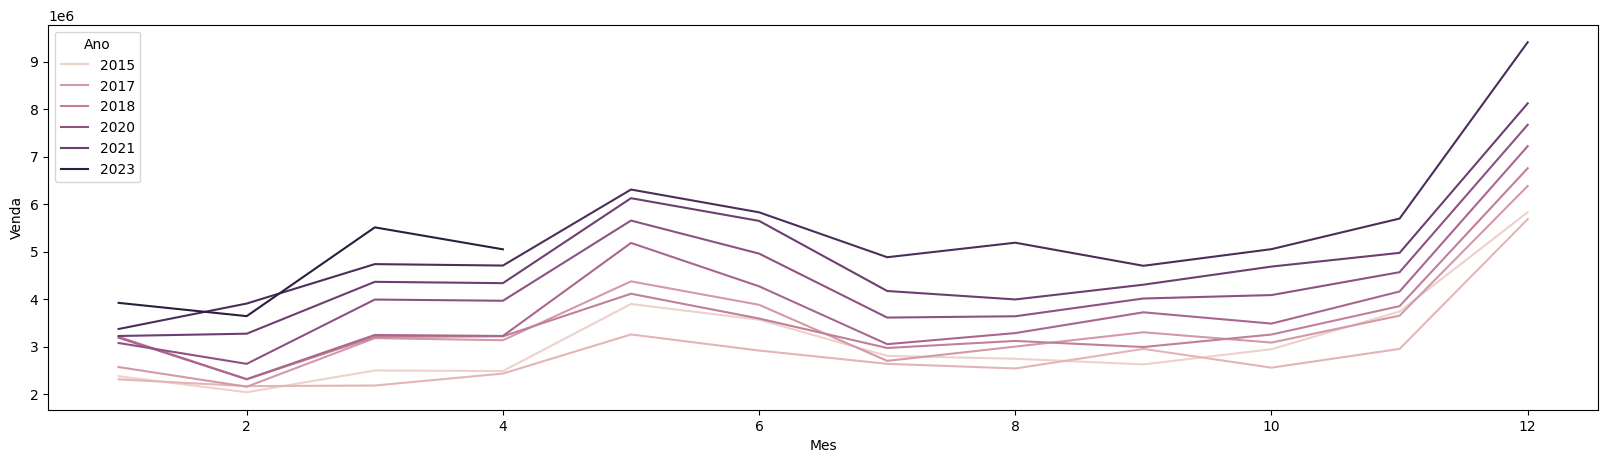

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Mes', y='Venda', hue='Ano', data=original_dataset)
plt.show()

Autocorrelation (ACF): sumariza de forma gráfica a força do relacionamentro entre observações da série temporal (direta e indiretamente). O que está dentro da área em azul não é estatisticamente significante.

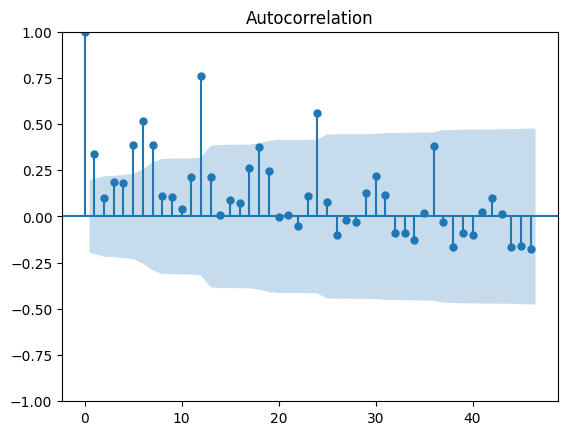

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(dataset['Venda'], lags=46)
plt.show()

PartialAutocorrelation (PACF): relação direta

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


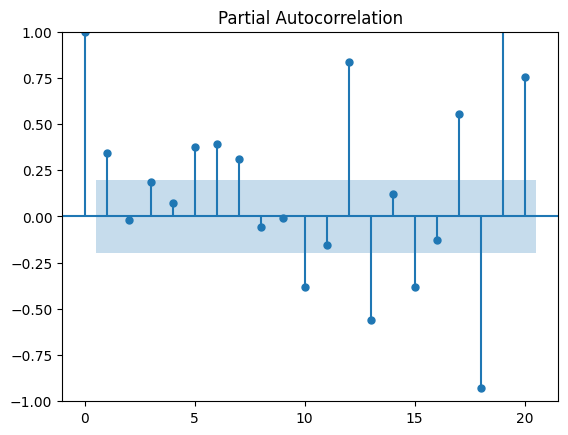

In [ ]:
plot_pacf(dataset['Venda']);

Criar janelamento

In [ ]:
#window = 12
#dataSize = len(dataset)
#X = []
#y = []
#for i in range(window, dataSize):
#    X.append(dataset.iloc[i-window:i, 0])
#    y.append(dataset.iloc[i, 0])
#X, y = np.array(X), np.array(y)

In [ ]:
# Criar a estrutura de dados com janela 3 pra trás + o mesmo mês no ano passado e 1 output
window = 12  # o mês exato para trás
look_back = 3  # quantos meses consecutivos para trás
dataSize = len(scaled_df)
X = []
y = []
for i in range(window, dataSize):
    X.append(np.hstack((scaled_df.iloc[i-window,0], scaled_df.iloc[i-look_back:i,0])))
    y.append(scaled_df.iloc[i, 0])
X, y = np.array(X), np.array(y)

In [ ]:
print(X.shape)
print(y.shape)

print(X[0:5])
print(y[0:5])

(88, 4)
(88,)
[[0.04567484 0.12289966 0.23058138 0.5141674 ]
 [0.         0.23058138 0.5141674  0.03674234]
 [0.06212171 0.5141674  0.03674234 0.01738428]
 [0.0604639  0.03674234 0.01738428 0.01913466]
 [0.25207511 0.01738428 0.01913466 0.05330443]]
[0.03674234 0.01738428 0.01913466 0.05330443 0.16505475]


Separar em treino e teste

In [ ]:
import random
np.random.seed(0) #semente inicial (reprodução de resultados)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.1)

# imprimir
print(x_train[0:5])

print()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print()

print(x_train)

[[0.3619217  0.25528365 0.21740209 0.47104286]
 [0.0956023  0.16505475 0.11906912 0.08110762]
 [0.154462   0.58931382 0.15830136 0.03689149]
 [0.14185422 0.12641275 0.14657345 0.12915781]
 [0.26133958 0.16064686 0.16722599 0.31539332]]

(79, 4)
(79,)
(9, 4)
(9,)

[[0.3619217  0.25528365 0.21740209 0.47104286]
 [0.0956023  0.16505475 0.11906912 0.08110762]
 [0.154462   0.58931382 0.15830136 0.03689149]
 [0.14185422 0.12641275 0.14657345 0.12915781]
 [0.26133958 0.16064686 0.16722599 0.31539332]
 [0.07952893 0.11906912 0.08110762 0.06789724]
 [0.16505475 0.01570042 0.154462   0.1485863 ]
 [0.07191209 0.14185422 0.21883841 0.58931382]
 [0.22831664 0.39603271 0.21327867 0.21702696]
 [0.55438442 0.25337734 0.36600495 0.3619217 ]
 [0.12641275 0.16075747 0.42654213 0.30256215]
 [0.12377301 0.13036761 0.17126649 0.14185422]
 [0.10380667 0.05330443 0.16505475 0.11906912]
 [0.08107477 0.34298261 0.76413086 0.16064686]
 [0.1556456  0.19612619 0.28779155 0.7029657 ]
 [0.26507349 0.5791293  0.51399

RNN

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(20, input_shape = x_train.shape[1:], activation = 'sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='linear')) # funcao de ativacao eh linear

# Compilar e treinar o modelo
model.compile(loss='mean_squared_error')
model.fit(x_train, y_train, epochs=150, batch_size=8)

Epoch 1/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0554
Epoch 2/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0421
Epoch 3/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 4/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 5/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0396
Epoch 6/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0398
Epoch 7/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 8/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 9/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0374
Epoch 10/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0363
Epoch 11/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 12/150
10/10 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 13/150
10/10 [=================

Fazer as previsões

In [ ]:
train_predictions = model.predict(x_train)
y_pred = model.predict(x_test)

print(model.summary())

print(y_pred)

1/1 [==============================] - 0s 30ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 20)                100       
                                                                 
 dense_15 (Dense)            (None, 1)                 21        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
None
[[0.10933413]
 [0.03391708]
 [0.364831  ]
 [0.25738558]
 [0.27486265]
 [0.1194775 ]
 [0.19766694]
 [0.19758156]
 [0.5681739 ]]


In [ ]:
#Desnormalizando dados

In [ ]:


#scaler = preprocessing.MinMaxScaler()
#d = scaler.fit_transform(dataset)

#scaled_df = pd.DataFrame(d)
#scaled_df = scaled_df.rename(columns={0: "venda"})
#scaled_df.head()

y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
print (y_test)
y_pred =scaler.inverse_transform(y_pred.reshape(-1,1))
print(y_pred)

[[2178929.]
 [2153625.]
 [4955970.]
 [4267265.]
 [4169274.]
 [2969370.]
 [3483029.]
 [3283016.]
 [5825140.]]
[[2843532.2]
 [2287848. ]
 [4726071. ]
 [3934397.2]
 [4063171.2]
 [2918270. ]
 [3494381.5]
 [3493752.2]
 [6224332. ]]


Calcular métricas de erro

Resultados de Teste
RMSE:  305710.4086427219
MSE:  93458853952.5
MAPE:  7.448525899297888 %
R2:  0.9304585416724696


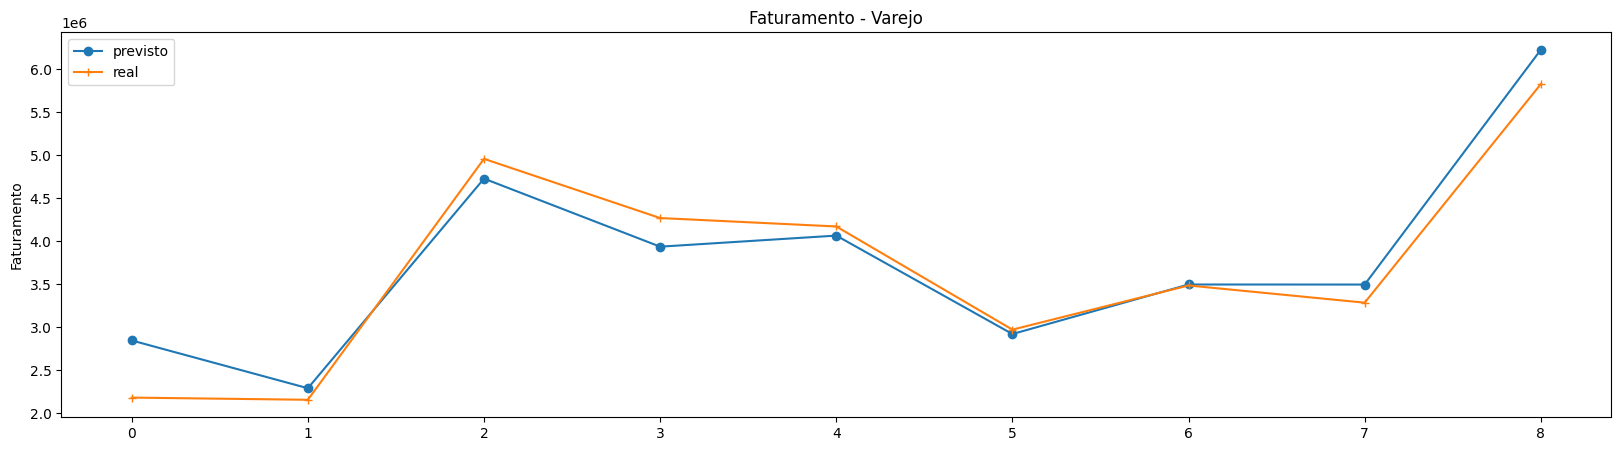

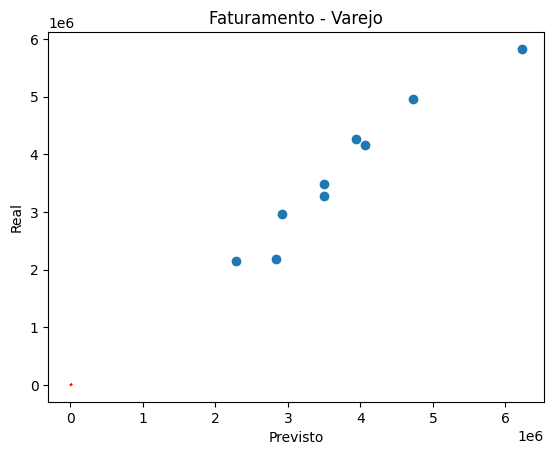

In [ ]:
def evaluate(y_test, y_pred):
  import math
  from sklearn.metrics import mean_squared_error
  rmse = math.sqrt(mean_squared_error(y_test, y_pred))
  print('RMSE: ', rmse)

  mse = mean_squared_error(y_test, y_pred)
  print('MSE: ',mse)

  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
  print('MAPE: ',mape, '%')

  from sklearn.metrics import r2_score
  r2 = r2_score(y_test, y_pred)
  print('R2: ', r2)

  # Gráfico 1
  plt.figure(figsize=(20,5))
  plt.plot(y_pred, label='previsto', marker='o')
  plt.plot(y_test, label='real', marker='+')
  plt.ylabel("Faturamento")
  plt.title("Faturamento - Varejo")
  plt.legend()
  plt.show()

  # Gráfico 2
  plt.scatter(y_pred,y_test)
  plt.ylabel("Real")
  plt.xlabel("Previsto")
  plt.title("Faturamento - Varejo")

  x = [5000.0, 14500.0]
  plt.plot(x, x, color='red'); # reta onde y=x (modelo perfeito)

  plt.show()

print('Resultados de Teste')
evaluate(y_test, y_pred)